# Learning Disentangled Representations for Equivariant Inference: A Tutorial

In this notebook, we illustrate better the core ideas behind our paper while walking through a detailed synthetic experiment in the context of uncertainty quantification. We start by properly defining the terms we use.

**Invariance/Equivariance:** We use the same definitions as Geometric Deep Learning. Namely, $f$ is invariant (equivariant) if $f(x) = f(g\cdot x), \forall g \in \mathbb{G}$ ($g\cdot f(x) = f(g\cdot x)$). E.g., an image classifier should be invariant to translations, this is the main idea behind CNNs. What is peculiar to our work is that:
1. We consider finite symmetry groups, which could be discretized rotations or translations, or any other abstract symmetry group.
2. We go beyond just regression or classification, which learn the conditional mean $\mathbb{E}[Y \mid X = x]$, to learn the full conditional distribution $P_{Y\mid X = x}$. Also, note we don't require any new assumptions compared to Geometric Deep Learning, as augmentations and/or equivariance/invariance constraint already implicitely impose the symmetry priors we assume on eqs. 1(a-c).

**Equivariant Inference:** We take this to mean all problems that can be solved by learning the conditional distribution $P_{Y \mid X = x}$, including regressing equivariant functions, constructing confidence intervals, and estimating conditional densities $p_{Y\mid X}(y\mid x)$.

**Learning Representations:** This is where operators and functional analysis enter the picture. We build on ideas reminiscent from conditional mean embeddings literature to *represent* the conditional probability $P_{Y\mid X}$ as an operator (infinite-dimensional matrix) $\mathbb{E}_{Y\mid X}$. Then, following Kostic et al. (2024), we leverage the crucial fact that learning the truncated SVD of the conditional expectation operator w.r.t. Hilbert-Schmidt norm is equivalent to spectral contrastive learning, where instead of learning only representation for $x$, we learn for $x$ and $y$ at the same time. This connection is non-trivial and is precisely what enables us to give the statistical learning theory results.

**Learning Disentangled Representations:** Having reconciled operator theory and functional analysis with deep representation learning via spectral contrastive learning, we can now consider the symmetry priors and group representation theory. The key result here is Cartan's Theorem, which says that our symmetry priors (eqs. 1(a-c)) induce a decomposition of the function spaces where $\mathbb{E}_{Y\mid X}$ is defined. Namely, $\mathcal{L}^2_{P_X} = \sum^\perp_{k \in [1, n_\text{iso}]} \mathcal{L}_{P_X}^{2, (k)}$ (similarly for $\mathcal{L}_{P_Y}^2$). This decomposition breaks our infinite-dimensional feature spaces $\mathcal{L}^2_{P_X}$ and $\mathcal{L}^2_{P_Y}$ into subspaces which are $\mathbb{G}^{(k)}$-equivariant, showing a close connection to the concept of disentangled linear representations as defined by Higgins et al. (2018). This decomposition also reduces the problem to learning $n_\text{iso}$ smaller operators $\mathbb{E}_{Y\mid X}^{(k)}$, which we again do by putting ($\mathbb{G}$-equivariant) features on $x$ and $y$ and then performing spectral contrastive learning. The main methodological step we had to take is in how to juggle between isotypic and regular bases, which we solve in Section 4.2.

**Putting Everything Together:** Our method can be seen as spectral contrastive learning to learn embeddings $u$ and $v$ of $x$ and $y$ which turn nonlinear regression, uncertainty quantification, and conditional density estimation problems into linear problems on $u$ and $v$ (we will further illustrate this in the Camera Ready). Our key contribution compared to Kostic et al. (2024) lies in showing how to leverage common Geometric Deep Learning assumptions to make this approach more sample-efficient and generalizable when learning $\mathbb{G}$-equivariant (in a way, disentangled!) features.

# Dataset

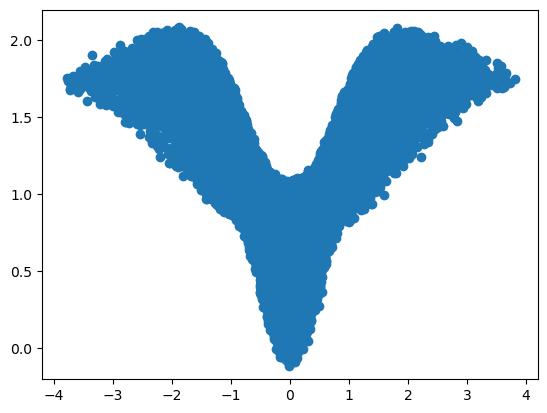

In [1]:
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


def synthetic_dataset(n: int, p: int = 1, condition_on_x: torch.Tensor = None):
    """Synthetic dataset from https://arxiv.org/abs/2110.00816, Appendix B.1.

    Args:
        n: sample size
        p: number of features. Defaults to 1 (used in the paper).
        condition_on_x: If None, generates marginal model. If Tesor, expects shape (1, p).
    """
    beta_hat = torch.rand(size=(n, p))
    beta = beta_hat / torch.linalg.norm(beta_hat, ord=1, dim=1, keepdim=True)
    z = 2 * torch.pi * torch.rand(size=(n, p)) - torch.pi
    phi = 2 * torch.pi * torch.rand(size=(n, p))
    r = 2 * 0.1 * torch.rand(size=(n, p)) - 0.1
    if condition_on_x is None:
        x = (3.2 - 0.8) * torch.rand(size=(n, p)) + 0.8
        y_0 = z / (beta * x).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(x.mean(dim=1, keepdim=True))
    else:
        x = condition_on_x
        y_0 = z / (beta * x).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(x.mean(dim=1, keepdim=True))

    return x, y_0, y_1


# Plot marginal of Y = (Y_0, Y_1), Fig. 1 (left) of https://arxiv.org/abs/2110.00816
x, y_0, y_1 = synthetic_dataset(n=20000, p=1)
fig, ax = plt.subplots()
offset = 0.2
ax.set_xlim(-4 - offset, 4 + offset)
ax.set_ylim(0 - offset, 2 + offset)
ax.scatter(y_0, y_1)

### Plotting Conditional Distributions

x: 1.50
	Quantiles: Y_0 [-1.99, 1.99] Y_1 [0.97, 2.02]
	Empirical Coverage: 91.15% Set Size: 4.17
x: 2.00
	Quantiles: Y_0 [-1.50, 1.49] Y_1 [0.88, 1.94]
	Empirical Coverage: 91.16% Set Size: 3.14
x: 2.50
	Quantiles: Y_0 [-1.19, 1.20] Y_1 [0.57, 1.62]
	Empirical Coverage: 91.09% Set Size: 2.51


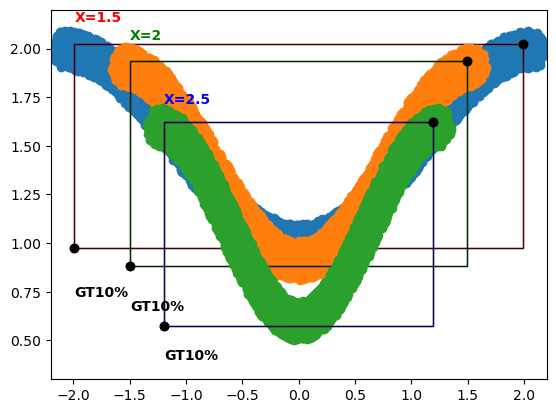

In [17]:
from matplotlib.patches import Rectangle
import numpy as np


def plot_quantiles(
    low_q,
    up_q,
    y_c: torch.Tensor = None,
    alpha: float = 0.05,
    ax: plt.Axes = None,
    label: str = "pred",
    quantile_color: str = "red",
):
    """Plots the predicted quantiles against (empirical) ground truth quantiles.

    Args:
        low_q (np.ndarray): The lower quantiles predicted by the model.
        up_q (np.ndarray): The upper quantiles predicted by the model.
        y_c (torch.Tensor, optional): The data to compute the ground truth quantiles. Defaults to None.
        alpha (float, optional): Miscoverage level. Defaults to 0.05 for 95% coverage.
        ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new figure and axis are created.
        label (str, optional): The label for the predicted quantiles. Defaults to "pred".
        quantile_color (str, optional): Color for confidence region. Defaults to "red".
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Add rectangle for the predicted quantiles
    ax.scatter(low_q[0], low_q[1], color=quantile_color)
    ax.scatter(up_q[0], up_q[1], color=quantile_color)
    pred_rect = Rectangle(
        (low_q[0], low_q[1]),
        up_q[0] - low_q[0],
        up_q[1] - low_q[1],
        edgecolor=quantile_color,
        facecolor="none",
        alpha=0.8,
    )
    ax.add_patch(pred_rect)
    ax.text(low_q[0], up_q[1] * 1.05, label, color=quantile_color, verticalalignment="bottom", fontweight="bold")

    # Add rectangle for the ground truth quantiles
    if y_c is not None:
        low_q_gt, up_q_gt = np.quantile(y_c, alpha / 4, axis=0), np.quantile(y_c, 1 - (alpha / 4), axis=0)
        ax.scatter(low_q_gt[0], low_q_gt[1], color="black")
        ax.scatter(up_q_gt[0], up_q_gt[1], color="black")
        gt_rect = Rectangle(
            (low_q_gt[0], low_q_gt[1]),
            up_q_gt[0] - low_q_gt[0],
            up_q_gt[1] - low_q_gt[1],
            edgecolor="black",
            facecolor="none",
            alpha=0.8,
        )
        ax.add_patch(gt_rect)
        ax.text(
            low_q_gt[0],
            low_q_gt[1] * 0.8,
            f"GT{int(alpha * 100):d}%",
            color="black",
            verticalalignment="top",
            horizontalalignment="left",
            fontweight="bold",
        )
    return fig, ax


# Plot conditional of Y = (Y_0, Y_1) | X = [1.5, 2, 2.5] along with 90% confidence regions, Fig. 1 (right) of https://arxiv.org/abs/2110.00816
fig, ax = plt.subplots(ncols=1)
x = [1.5, 2, 2.5]
offset = 0.2
ax.set_xlim(-2 - offset, 2 + offset)
ax.set_ylim(0.5 - offset, 2 + offset)
alpha = 0.1
for j, color in zip(range(3), ["red", "green", "blue"]):
    # Plot conditional distribution
    _, y_0, y_1 = synthetic_dataset(n=20000, condition_on_x=torch.Tensor([x[j]]).reshape(-1, 1))
    ax.scatter(y_0, y_1)

    # Plot confidence regions
    y_cond_x = np.hstack([y_0, y_1])
    low_q_gt, up_q_gt = np.quantile(y_cond_x, alpha / 4, axis=0), np.quantile(y_cond_x, 1 - (alpha / 4), axis=0)
    plot_quantiles(
        y_c=y_cond_x, low_q=low_q_gt, up_q=up_q_gt, alpha=alpha, ax=ax, label=f"X={x[j]}", quantile_color=color
    )
    coverage = (
        (low_q_gt <= y_cond_x).all(axis=1, keepdims=True) & (y_cond_x <= up_q_gt).all(axis=1, keepdims=True)
    ).mean()
    set_size = np.abs(up_q_gt - low_q_gt).prod()
    print(f"x: {x[j]:.2f}")
    print(f"\tQuantiles: Y_0 [{low_q_gt[0]:.2f}, {up_q_gt[0]:.2f}] Y_1 [{low_q_gt[1]:.2f}, {up_q_gt[1]:.2f}]")
    print(f"\tEmpirical Coverage: {coverage * 100:.2f}% Set Size: {set_size:.2f}")

# Conformalized Quantile Regression

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# CONFIG================================================================================================================
SAMPLE_SIZE = 20000  # (Table 4)
BATCH_SIZE = 1024  # (Appendix C)
EPOCHS = 1000
DEVICE = "cuda:0"
# ======================================================================================================================

# GET DATA==============================================================================================================
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1)
y = torch.hstack([y_0, y_1])

# Split dataset intro train, calibration, validation, and test
ntrain, ncal, nval, ntest = (
    int(0.384 * SAMPLE_SIZE),
    int(0.256 * SAMPLE_SIZE),
    int(0.16 * SAMPLE_SIZE),
    int(0.2 * SAMPLE_SIZE),
)
x_train, y_train = x[: ntrain + ncal, :], y[: ntrain + ncal, :]
x_train_mlp, y_train_mlp = x[:ntrain, :], y[:ntrain, :]
x_cal, y_cal = x[ntrain : ntrain + ncal, :], y[ntrain : ntrain + ncal, :]
x_val, y_val = x[ntrain + ncal : ntrain + ncal + nval, :], y[ntrain + ncal : ntrain + ncal + nval, :]
x_test, y_test = x[ntrain + ncal + nval :, :], y[ntrain + ncal + nval :, :]
print(f"Sanity check: train={x_train.shape[0]}, cal={x_cal.shape[0]}, val={x_val.shape[0]}, test={x_test.shape[0]}")

# Standardize datasets
x_train_mean = x_train.mean(dim=0)
y_train_mean = y_train.mean(dim=0)
x_train_std = x_train.std(dim=0)
y_train_std = y_train.std(dim=0)

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std
x_train_mlp = (x_train_mlp - x_train_mean) / x_train_std
y_train_mlp = (y_train_mlp - y_train_mean) / y_train_std

x_cal = (x_cal - x_train_mean) / x_train_std
y_cal = (y_cal - y_train_mean) / y_train_std

x_val = (x_val - x_train_mean) / x_train_std
y_val = (y_val - y_train_mean) / y_train_std

x_test = (x_test - x_train_mean) / x_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Wrap tensors into Dataset and DataLoader
train_ds = TensorDataset(x_train, y_train)
train_mlp_ds = TensorDataset(x_train_mlp, y_train_mlp)
cal_ds = TensorDataset(x_cal, y_cal)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
train_dl_mlp = DataLoader(train_mlp_ds, shuffle=True, batch_size=BATCH_SIZE)
cal_dl = DataLoader(cal_ds, shuffle=False, batch_size=len(cal_ds))
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

Sanity check: train=12800, cal=5120, val=3200, test=4000


# Naive Multivariate Conformalized Quantile Regression (Use This!)

In [ ]:
from torch.nn import Sequential, Linear, BatchNorm1d
from tqdm import tqdm
import math


def pinball_loss(input: torch.Tensor, target: torch.Tensor, gamma: float):
    """Pinball loss of https://arxiv.org/pdf/2107.07511 (page 8) to learn (gamma/2)-quantiles.

    Args:
        input: Model output.
        target: Ground truth.
        gamma: Quantile to regress.

    """
    errors = target - input
    loss = torch.maximum(errors * gamma, -errors * (1 - gamma)).mean()
    return loss


def make_mlp(
    input_dim: int = 1,
    output_dim: int = 2,
    layer_size: int = 32,
    n_hidden: int = 2,
    activation: torch.nn.Module = torch.nn.ELU,
):
    layers = [Linear(input_dim, layer_size), activation(), BatchNorm1d(layer_size)]
    for _ in range(n_hidden - 1):
        layers += [Linear(layer_size, layer_size), activation(), BatchNorm1d(layer_size)]
    layers += [Linear(layer_size, output_dim), activation()]
    return Sequential(*layers)


# GET MODEL=============================================================================================================
lower_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden=3).to(DEVICE)
upper_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden=3).to(DEVICE)

# TRAIN MODEL===========================================================================================================
opt_lo = torch.optim.Adam(lower_quantile_estimator.parameters())
opt_up = torch.optim.Adam(upper_quantile_estimator.parameters())


def train(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    train_dl: DataLoader,
    opt_lo: torch.optim.Optimizer,
    opt_up: torch.optim.Optimizer,
):
    lo_q_est.train()
    up_q_est.train()
    for batch, (x, y) in enumerate(train_dl):
        x, y = x.to(DEVICE), y.to(DEVICE)
        q_lo, q_up = lo_q_est(x), up_q_est(x)

        loss_lo = pinball_loss(input=q_lo, target=y, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y, gamma=1 - ALPHA / 2)

        loss_lo.backward()
        loss_up.backward()

        opt_lo.step()
        opt_up.step()

        opt_lo.zero_grad()
        opt_up.zero_grad()


for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    # print(f"EPOCH: {epoch}")
    train(
        lo_q_est=lower_quantile_estimator,
        up_q_est=upper_quantile_estimator,
        train_dl=train_dl_mlp,
        opt_lo=opt_lo,
        opt_up=opt_up,
    )

    # if epoch % 25 == 0:
    # validate()

# CALIBRATION===========================================================================================================


def calibrate(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    cal_ds: TensorDataset,
):
    lo_q_est.eval()
    up_q_est.eval()
    n_cal = len(cal_ds)
    adjusted_alpha = math.ceil((n_cal + 1) * (1 - ALPHA)) / n_cal

    with torch.no_grad():
        x, y = cal_ds.tensors
        x, y = x.to(DEVICE), y.to(DEVICE)

        q_lo, q_up = lo_q_est(x), up_q_est(x)

        nonconformity_scores = torch.maximum(q_lo - y, y - q_up).max(dim=1, keepdim=True)[0]

        q_hat = torch.quantile(nonconformity_scores, adjusted_alpha, interpolation="higher").item()

        return q_hat


q_hat = calibrate(lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, cal_ds=cal_ds)
print(f"Empirical Quantile Estimated with CP: {q_hat}")


# EVALUATION============================================================================================================
def test_mlp(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, test_dl: DataLoader, q_hat: float):
    coverage = 0
    set_size = 0
    lo_q_est.eval()
    up_q_est.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Conformalize quantile estimates
            q_lo, q_up = lo_q_est(x) - q_hat, up_q_est(x) + q_hat

            coverage += ((q_lo <= y).all(dim=1, keepdim=True) & (y <= q_up).all(dim=1, keepdim=True)).type_as(y).mean()
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


coverage, set_size = test_mlp(
    lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, test_dl=test_dl, q_hat=q_hat
)
print(f"Avg. empirical coverage: {coverage.item() * 100:.2f}% Avg. set size: {set_size.item():.2f}")

Epochs: 100%|██████████| 1000/1000 [00:48<00:00, 20.60it/s]

Empirical Quantile Estimated with CP: 1.1042437553405762
Avg. empirical coverage: 95.38% Avg. set size: 19.75


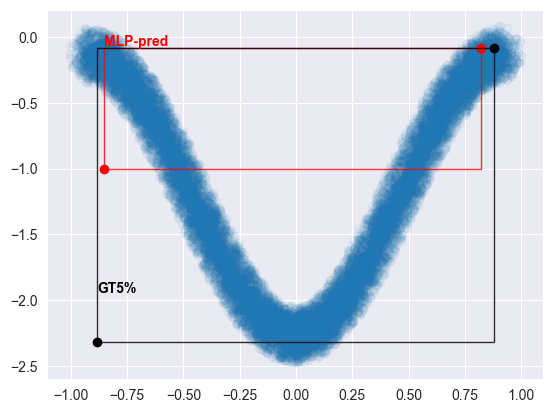

In [41]:
# Quantile Regression, Fig 2 of https://arxiv.org/abs/2110.00816

x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([3.0]).reshape(1, 1))
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x - x_train_mean) / x_train_std
low_q = torch.squeeze(lower_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()
up_q = torch.squeeze(upper_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()


# Compute the empirical quantiles GT.
q_up_gt, q_lo_gt = np.quantile(y_c, ALPHA, axis=0), np.quantile(y_c, ALPHA, axis=0)

y_c = y_c.cpu().numpy()

fig, ax = plot_quantiles(y_c, low_q, up_q, label="MLP-pred", alpha=ALPHA)

# NCP training

Epochs: 100%|██████████| 1000/1000 [01:59<00:00,  8.36it/s, loss=-1.36, tr(Cx)=0.417, tr(Cy)=0.964, val_loss=-1.26, ||k(x,y) - k_r(x,y)||=-2.92]   


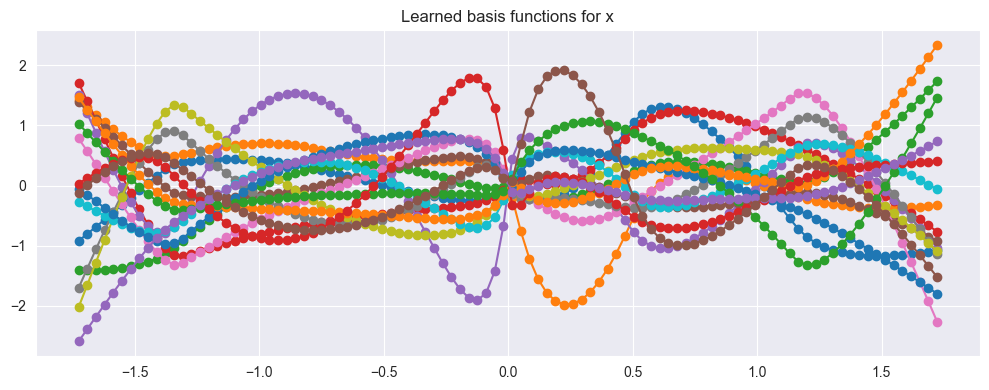

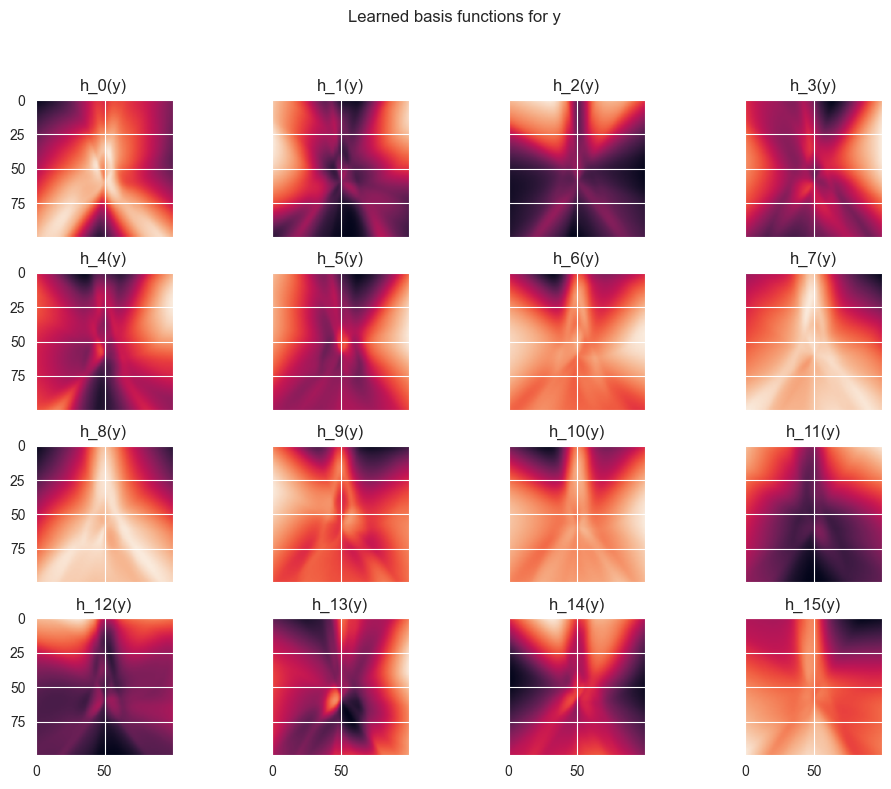

In [25]:
import numpy as np
from symm_rep_learn.nn.layers import MLP
from symm_rep_learn.models.ncp import NCP

embedding_dim = 16
ncp = NCP(
    embedding_x=MLP(input_shape=1, output_shape=embedding_dim, layer_size=64, n_hidden=3, activation=torch.nn.ELU),
    embedding_y=MLP(input_shape=2, output_shape=embedding_dim, layer_size=64, n_hidden=3, activation=torch.nn.ELU),
    embedding_dim=embedding_dim,
    gamma=5,
).to(DEVICE)

lr = 5e-4
ncp_optimizer = torch.optim.Adam(ncp.parameters(), lr=lr)

CHECK_VAL_EVERY_N_EPOCHS = int(EPOCHS / 10)
# Initialize the progress bar
pbar = tqdm(range(EPOCHS), desc="Epochs")

relevant_metrics = ["tr(Cx)", "tr(Cy)", "||k(x,y) - k_r(x,y)||"]
val_loss = np.infty
for epoch in pbar:
    ncp.train()
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        ncp_optimizer.zero_grad()
        fx, hy = ncp(x, y)
        loss, metrics = ncp.loss(fx, hy)

        loss.backward()
        ncp_optimizer.step()

        # Update the progress bar with the loss
        pbar.set_postfix(
            loss=loss.item(), val_loss=val_loss, **{k: v for k, v in metrics.items() if k in relevant_metrics}
        )
    if epoch % CHECK_VAL_EVERY_N_EPOCHS == 0:
        ncp.eval()
        with torch.no_grad():
            val_loss = 0

            for x, y in val_dl:
                x, y = x.to(DEVICE), y.to(DEVICE)
                fx, hy = ncp(x, y)
                loss, metrics = ncp.loss(fx, hy)
                val_loss += loss.item()
                pbar.set_postfix(val_loss=loss)
            val_loss /= len(val_dl)
        # print('', end='\n')


# Plot the learned basis functions for x ==============================================================
x_range = torch.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1).to(DEVICE)
with torch.no_grad():
    fx = ncp.embedding_x(x_range)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
for i in range(embedding_dim):
    ax.plot(x_range.cpu().numpy(), fx[:, i].cpu().numpy(), marker="o", label=f"f_{i}(x)")
fig.set_tight_layout(True)
ax.set_title("Learned basis functions for x")
# Plot the learned basis functions for y ==============================================================
# Plot the `embedding_y` basis functions as 2D images.
N_GRID_POINTS = 100
y0_range = np.linspace(y_train[:, 0].min().numpy(), y_train[:, 0].max().numpy(), N_GRID_POINTS).reshape(-1)
y1_range = np.linspace(y_train[:, 1].min().numpy(), y_train[:, 1].max().numpy(), N_GRID_POINTS).reshape(-1)
# Generate the 2D grid of sample points
y0_grid, y1_grid = np.meshgrid(y0_range, y1_range)
y_grid = torch.tensor(np.vstack([y0_grid.ravel(), y1_grid.ravel()]).T, device=DEVICE, dtype=torch.float32)
with torch.no_grad():
    hy = ncp.embedding_y(y_grid)
    # Reshape back to 2D images (100, 100, embedding_dim)
    hy = hy.reshape(N_GRID_POINTS, N_GRID_POINTS, embedding_dim)

nrows = math.ceil(embedding_dim / 4)
fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(10, nrows * 2), sharey=True, sharex=True)
for i in range(embedding_dim):
    ax = axs[i // 4, i % 4]
    ax.imshow(hy[:, :, i].cpu().numpy())  # extent=(y0_range.min(), y0_range.max(), y1_range.min(), y1_range.max()))
    ax.set_title(f"h_{i}(y)")
fig.suptitle("Learned basis functions for y")
fig.tight_layout(rect=[0, 0, 1, 0.95])

## Use NCP for quantile regression

Avg. empirical coverage: 94.4% Avg - Expected 95.0. 
Set size: 7.59


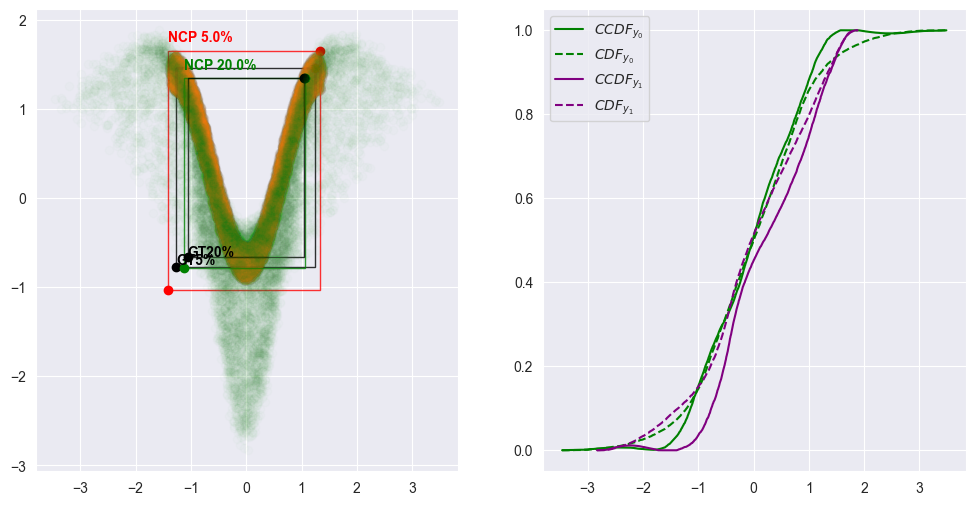

In [ ]:
from sklearn.isotonic import IsotonicRegression
from symm_rep_learn.inference.ncp import NCPConditionalCDF

x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([2.1]).reshape(1, 1))
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x - x_train_mean) / x_train_std

ncp_ccdf = NCPConditionalCDF(model=ncp, y_train=y_train, support_discretization_points=1000, lstsq=False)
# Estimate the conditional Cumulative Distribution Function (CCDF)
ccdf = ncp_ccdf(x_cond=x_c)

alphas = [0.05, 0.2]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # sharey=True, sharex=True)
for alpha, color in zip(alphas, ["red", "green", "purple"]):
    q_low, q_high = ncp_ccdf.conditional_quantiles(x_cond=x_c, alpha=alpha)
    plot_quantiles(y_c, q_low, q_high, label=f"NCP {alpha * 100:.1f}%", alpha=alpha, ax=axs[0], quantile_color=color)
    # PLot the marginal CDF of each dimension
axs[0].scatter(y_train[:, 0], y_train[:, 1], alpha=0.01)
axs[1].plot(ncp_ccdf.support_obs[:, 0], ccdf[0], label=r"$CCDF_{y_0}$", color="green")
axs[1].plot(
    ncp_ccdf.support_obs[:, 0], ncp_ccdf.marginal_CDF[:, 0], label=r"$CDF_{y_0}$", color="green", linestyle="--"
)
axs[1].plot(ncp_ccdf.support_obs[:, 1], ccdf[1], label=r"$CCDF_{y_1}$", color="purple")
axs[1].plot(
    ncp_ccdf.support_obs[:, 1], ncp_ccdf.marginal_CDF[:, 1], label=r"$CDF_{y_1}$", color="purple", linestyle="--"
)
axs[1].legend()


# EVALUATION============================================================================================================
def test_ncp_uc(model: NCPConditionalCDF, test_dl: DataLoader):
    coverage = 0
    set_size = 0
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)
            # Conformalize quantile estimates
            q_lo, q_up = model.conditional_quantiles(x_cond=x, alpha=ALPHA)
            q_lo = torch.tensor(q_lo, device=DEVICE, dtype=torch.float32)
            q_up = torch.tensor(q_up, device=DEVICE, dtype=torch.float32)
            coverage += ((q_lo <= y).all(dim=1, keepdim=True) & (y <= q_up).all(dim=1, keepdim=True)).type_as(y).mean()
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


coverage, set_size = test_ncp_uc(model=ncp_ccdf, test_dl=test_dl)
print(
    f"Avg. empirical coverage: {coverage.item() * 100:.1f}% Avg - "
    f"Expected {(1 - ALPHA) * 100:.1f}. \nSet size: {set_size.item():.2f}"
)

# NCP can be queried for arbitrary quantiles without retraining the model, unlike the MLP model.


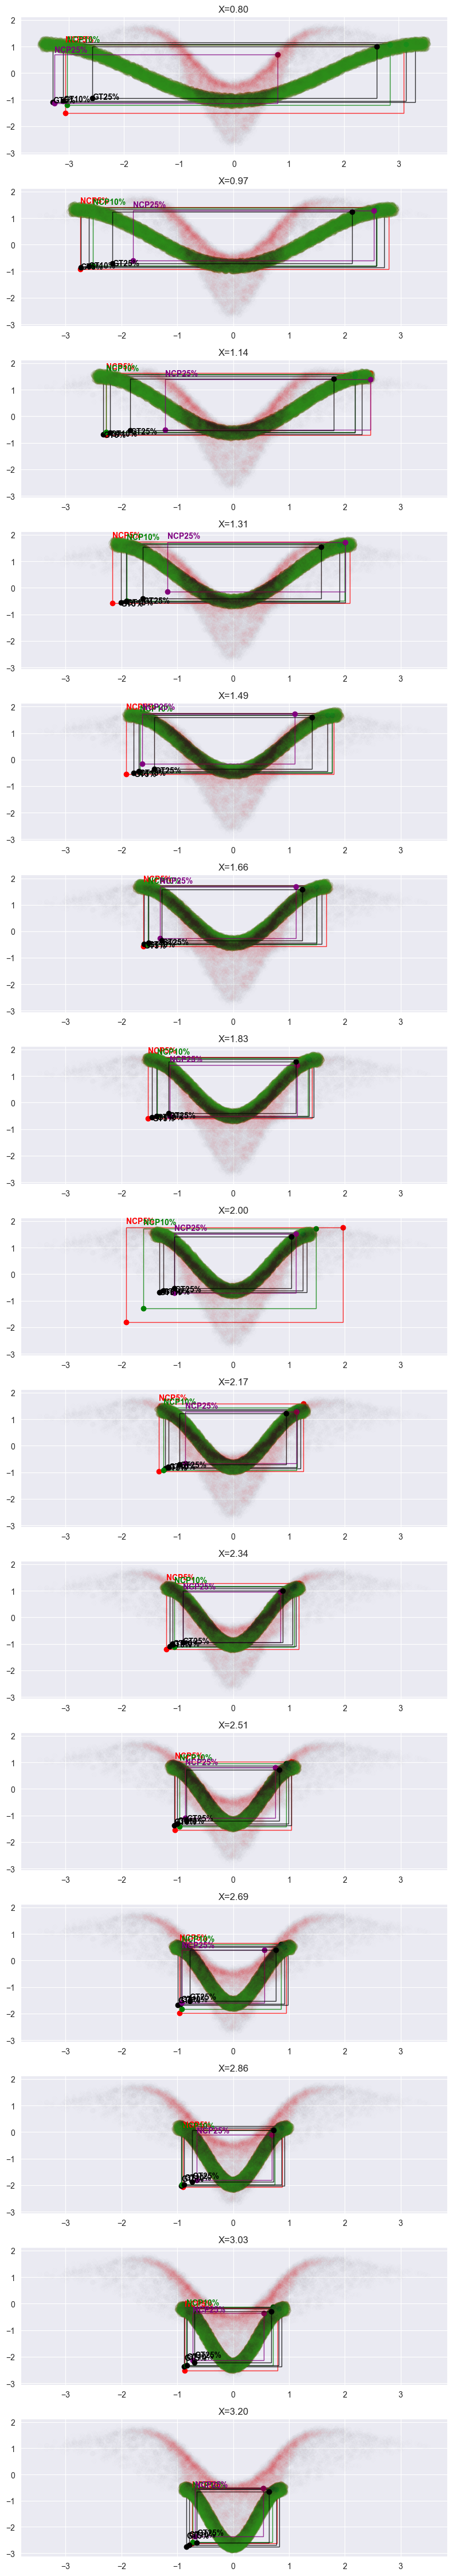

In [ ]:
N_COND_POINTS = 15
x_range = torch.linspace(X_MIN, X_MAX, N_COND_POINTS).reshape(-1, 1, 1).to(dtype=torch.float32)

fig, axs = plt.subplots(N_COND_POINTS, 1, figsize=(8, N_COND_POINTS * 3))
for i, x_cond in enumerate(x_range):
    _, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([x_cond]).reshape(1, 1))
    y = torch.hstack([y_0, y_1])
    y_c = (y - y_train_mean) / y_train_std
    x_c = ((x_cond - x_train_mean) / x_train_std).to(DEVICE)
    # NCP quantile predictions.
    ccdf = ncp_ccdf(x_cond=x_c)
    for alpha, color in zip([0.05, 0.1, 0.25], ["red", "green", "purple"]):
        q_lo_ncp, q_up_ncp = ncp_ccdf.conditional_quantiles(x_cond=x_c, alpha=alpha)
        # Plot the quantile predictions.
        plot_quantiles(
            y_c, q_lo_ncp, q_up_ncp, ax=axs[i], label=f"NCP{int(alpha * 100):d}%", alpha=alpha, quantile_color=color
        )
    axs[i].set_title(f"X={x_cond.item():.2f}")
    axs[i].scatter(y_train[:, 0], y_train[:, 1], alpha=0.005)
fig.tight_layout()

# The Symmetry aware estimate
# Training E-NCP model

In [ ]:
from escnn.nn import FieldType
import numpy as np
from symm_rep_learn.nn.equiv_layers import EMLP
from symm_rep_learn.models.equiv_ncp import ENCP
from escnn.group import CyclicGroup
from escnn.gspaces import no_base_space

G = CyclicGroup(2)
x_type = FieldType(no_base_space(G), representations=[G.representations["irrep_0"]])
# y0 transforms by reflections g. y0 = -y0
# y1 transforms by invariance  g. y1 = y1
y_type = FieldType(no_base_space(G), representations=[G.representations["irrep_1"], G.representations["irrep_0"]])
embedding_dim = 16
lat_type = FieldType(no_base_space(G), representations=[G.regular_representation] * int(embedding_dim // G.order()))

encp = ENCP(
    embedding_x=EMLP(in_type=x_type, out_type=lat_type, hidden_units=64, hidden_layers=3, activation="ELU"),
    embedding_y=EMLP(in_type=y_type, out_type=lat_type, hidden_units=64, hidden_layers=3, activation="ELU"),
    gamma=5,
).to(DEVICE)

lr = 5e-4
encp_optimizer = torch.optim.Adam(encp.parameters(), lr=lr)

CHECK_VAL_EVERY_N_EPOCHS = int(EPOCHS / 10)
# Initialize the progress bar
pbar = tqdm(range(EPOCHS), desc="Epochs")
relevant_metrics = ["tr(Cx)", "tr(Cy)", "||k(x,y) - k_r(x,y)||"]
val_loss = np.infty
for epoch in pbar:
    encp.train()
    for x, y in train_dl:
        x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
        encp_optimizer.zero_grad()
        fx, hy = encp(x, y)
        loss, metrics = encp.loss(fx, hy)

        loss.backward()
        encp_optimizer.step()

        # Update the progress bar with the loss
        pbar.set_postfix(
            loss=loss.item(), val_loss=val_loss, **{k: v for k, v in metrics.items() if k in relevant_metrics}
        )
    if epoch % CHECK_VAL_EVERY_N_EPOCHS == 0:
        encp.eval()
        with torch.no_grad():
            val_loss = 0

            for x, y in val_dl:
                x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
                fx, hy = encp(x, y)
                loss, metrics = encp.loss(fx, hy)
                val_loss += loss.item()
                pbar.set_postfix(val_loss=loss)
            val_loss /= len(val_dl)

Epochs: 100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s, loss=-2.01, val_loss=-2.16, ||k(x,y) - k_r(x,y)||=-3.66]   


### Plot the learned basis functions for x and y.


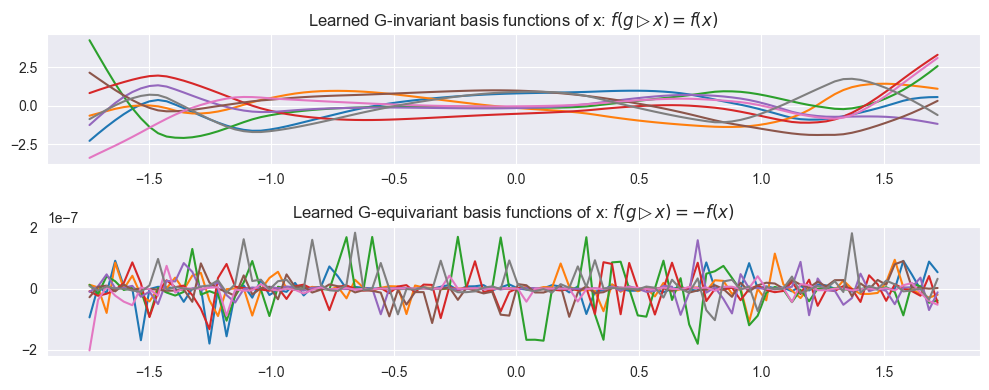

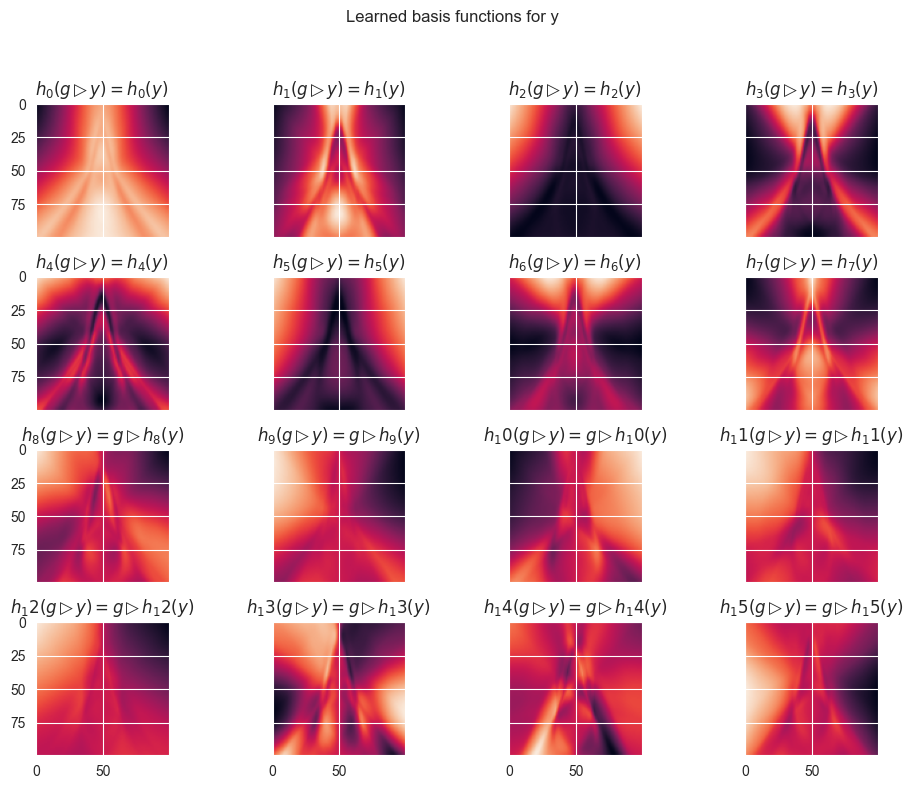

In [155]:
# Plot the learned basis functions for x ==============================================================
x_range = torch.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1).to(DEVICE)
with torch.no_grad():
    fx = encp.embedding_x(x_type(x_range)).tensor
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
for i in range(int(embedding_dim // 2)):
    axs[0].plot(x_range.cpu().numpy(), fx[:, i].cpu().numpy(), label=f"f_{i}(x)")
for i in range(int(embedding_dim // 2), embedding_dim):
    axs[1].plot(x_range.cpu().numpy(), fx[:, i].cpu().numpy(), label=f"f_{i}(x)")
axs[0].set_title(rf"Learned G-invariant basis functions of x: $f(g \triangleright x) = f(x)$")
axs[1].set_title(rf"Learned G-equivariant basis functions of x: $f(g \triangleright x) = -f(x)$")

fig.set_tight_layout(True)

# Plot the `embedding_y` basis functions as 2D images. ====================================================
N_GRID_POINTS = 100
y0_range = np.linspace(y_train[:, 0].min().numpy(), y_train[:, 0].max().numpy(), N_GRID_POINTS).reshape(-1)
y1_range = np.linspace(y_train[:, 1].min().numpy(), y_train[:, 1].max().numpy(), N_GRID_POINTS).reshape(-1)
# Generate the 2D grid of sample points
y0_grid, y1_grid = np.meshgrid(y0_range, y1_range)
y_grid = torch.tensor(np.vstack([y0_grid.ravel(), y1_grid.ravel()]).T, device=DEVICE, dtype=torch.float32)
with torch.no_grad():
    hy = encp.embedding_y(y_type(y_grid)).tensor
    # Reshape back to 2D images (100, 100, embedding_dim)
    hy = hy.reshape(N_GRID_POINTS, N_GRID_POINTS, embedding_dim)

nrows = math.ceil(embedding_dim / 4)
fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(10, nrows * 2), sharey=True, sharex=True)
for i in range(int(embedding_dim // 2)):
    ax = axs[i // 4, i % 4]
    ax.imshow(hy[:, :, i].cpu().numpy())  # extent=(y0_range.min(), y0_range.max(), y1_range.min(), y1_range.max()))
    ax.set_title(rf"$h_{i}(g \triangleright y) = h_{i}(y)$")
for i in range(int(embedding_dim // 2), embedding_dim):
    ax = axs[i // 4, i % 4]
    ax.imshow(hy[:, :, i].cpu().numpy())  # extent=(y0_range.min(), y0_range.max(), y1_range.min(), y1_range.max()))
    ax.set_title(rf"$h_{i}(g \triangleright y) = g \triangleright h_{i}(y)$")

fig.suptitle("Learned basis functions for y")
fig.tight_layout(rect=[0, 0, 1, 0.95])

## Use E-NCP for G-equivariant quantile regression

Avg. empirical coverage: 93.5% Avg - Expected 95.0. 
Set size: 7.41


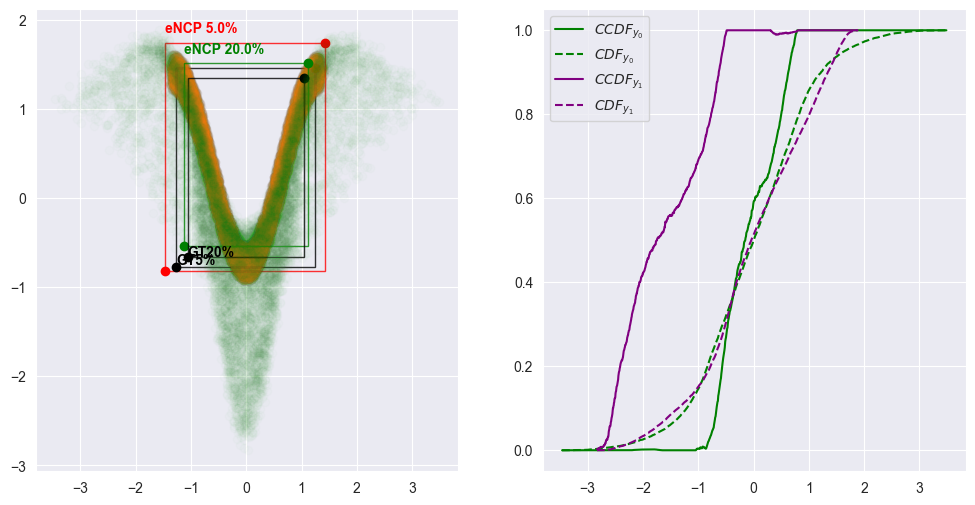

In [ ]:
from sklearn.isotonic import IsotonicRegression
from symm_rep_learn.inference.encp import ENCPConditionalCDF

x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([2.1]).reshape(1, 1))
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x - x_train_mean) / x_train_std

encp_ccdf = ENCPConditionalCDF(model=encp, y_train=y_type(y_train), support_discretization_points=1000, lstsq=False)
# Estimate the conditional Cumulative Distribution Function (CCDF)
equiv_ccdf = encp_ccdf(x_cond=x_type(x_c))

alphas = [0.05, 0.2]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # sharey=True, sharex=True)
for alpha, color in zip(alphas, ["red", "green", "purple"]):
    q_low, q_high = encp_ccdf.conditional_quantiles(x_cond=x_type(x_c), alpha=alpha)
    plot_quantiles(y_c, q_low, q_high, label=f"eNCP {alpha * 100:.1f}%", alpha=alpha, ax=axs[0], quantile_color=color)
    # PLot the marginal CDF of each dimension
axs[0].scatter(y_train[:, 0], y_train[:, 1], alpha=0.01)
axs[1].plot(ncp_ccdf.support_obs[:, 0], ccdf[0], label=r"$CCDF_{y_0}$", color="green")
axs[1].plot(
    ncp_ccdf.support_obs[:, 0], ncp_ccdf.marginal_CDF[:, 0], label=r"$CDF_{y_0}$", color="green", linestyle="--"
)
axs[1].plot(ncp_ccdf.support_obs[:, 1], ccdf[1], label=r"$CCDF_{y_1}$", color="purple")
axs[1].plot(
    ncp_ccdf.support_obs[:, 1], ncp_ccdf.marginal_CDF[:, 1], label=r"$CDF_{y_1}$", color="purple", linestyle="--"
)
axs[1].legend()


# EVALUATION============================================================================================================
def test_encp_uc(model: ENCPConditionalCDF, test_dl: DataLoader):
    coverage = 0
    set_size = 0
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
            # Conformalize quantile estimates
            q_lo, q_up = model.conditional_quantiles(x_cond=x, alpha=ALPHA)
            q_lo = torch.tensor(q_lo, device=DEVICE, dtype=torch.float32)
            q_up = torch.tensor(q_up, device=DEVICE, dtype=torch.float32)
            coverage += (
                ((q_lo <= y.tensor).all(dim=1, keepdim=True) & (y.tensor <= q_up).all(dim=1, keepdim=True))
                .type_as(y.tensor)
                .mean()
            )
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


coverage, set_size = test_encp_uc(model=encp_ccdf, test_dl=test_dl)
print(
    f"Avg. empirical coverage: {coverage.item() * 100:.1f}% Avg - "
    f"Expected {(1 - ALPHA) * 100:.1f}. \nSet size: {set_size.item():.2f}"
)

# Visual comparison between models



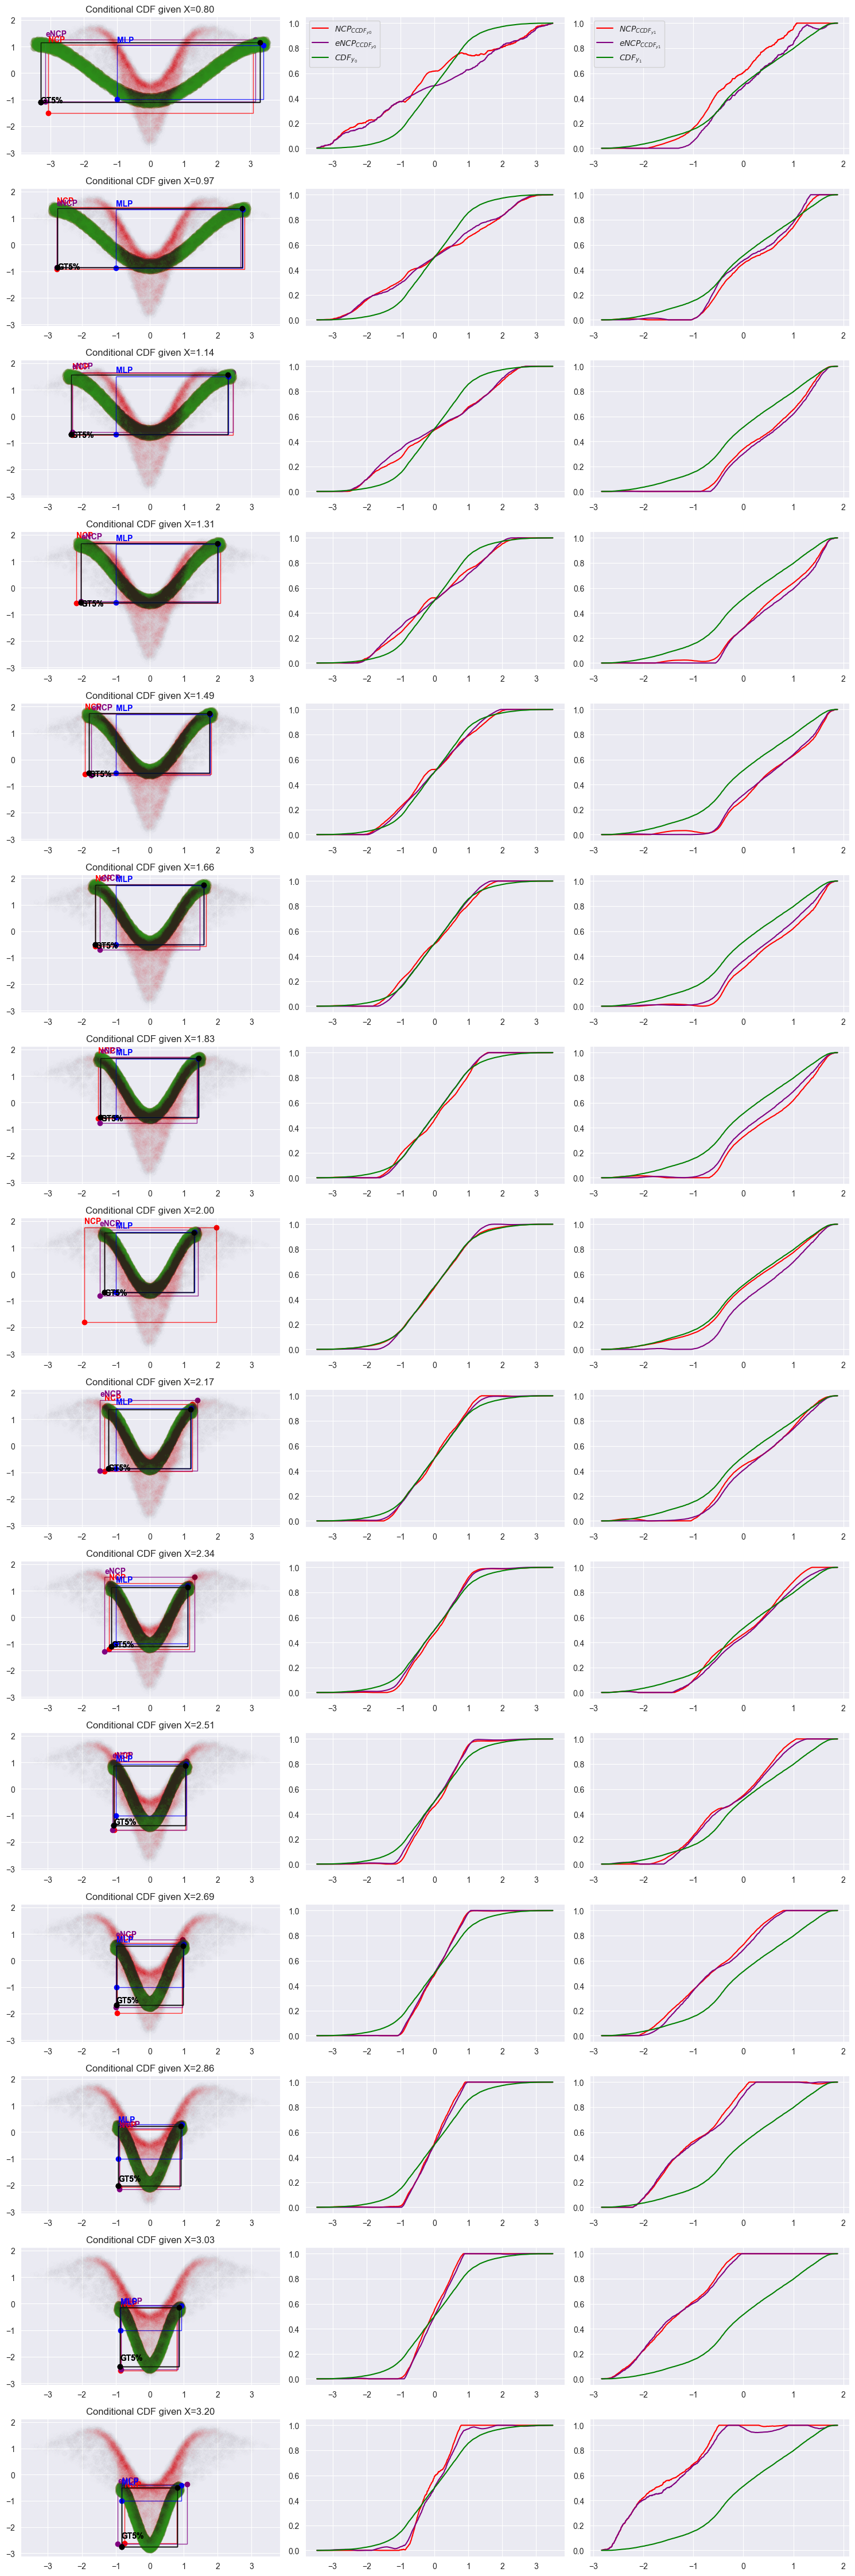

In [ ]:
N_COND_POINTS = 15
x_range = torch.linspace(X_MIN, X_MAX, N_COND_POINTS).reshape(-1, 1, 1).to(dtype=torch.float32)

fig, axs = plt.subplots(N_COND_POINTS, 3, figsize=(15, N_COND_POINTS * 3))
for i, x_cond in enumerate(x_range):
    _, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([x_cond]).reshape(1, 1))
    y = torch.hstack([y_0, y_1])
    y_c = (y - y_train_mean) / y_train_std
    x_c = ((x_cond - x_train_mean) / x_train_std).to(DEVICE)

    # NCP quantile predictions.
    q_lo_ncp, q_up_ncp = ncp_ccdf.conditional_quantiles(x_cond=x_c, alpha=ALPHA)
    ccdf = ncp_ccdf(x_cond=x_c)
    # ENCP quantile predictions.
    q_lo_encp, q_up_encp = encp_ccdf.conditional_quantiles(x_cond=x_type(x_c), alpha=ALPHA)
    eccdf = encp_ccdf(x_cond=x_type(x_c))
    # MLP quantile predictions.
    q_lo_mlp = torch.squeeze(lower_quantile_estimator(x_c)).detach().cpu().numpy()
    q_up_mlp = torch.squeeze(upper_quantile_estimator(x_c)).detach().cpu().numpy()
    # Plot the quantile predictions.
    plot_quantiles(y_c, q_lo_ncp, q_up_ncp, ax=axs[i, 0], label="NCP", alpha=ALPHA, quantile_color="red")
    plot_quantiles(y_c, q_lo_encp, q_up_encp, ax=axs[i, 0], label="eNCP", alpha=ALPHA, quantile_color="purple")
    plot_quantiles(y_c, q_lo_mlp, q_up_mlp, ax=axs[i, 0], label="MLP", alpha=ALPHA, quantile_color="blue")
    axs[i, 0].set_title(f"X={x_cond.item():.2f}")
    axs[i, 0].set_title(f"Conditional CDF given X={x_cond.item():.2f}")
    axs[i, 0].scatter(y_train[:, 0], y_train[:, 1], alpha=0.005)
    axs[i, 1].plot(ncp_ccdf.support_obs[:, 0], ccdf[0], label=r"$NCP_{CCDF_{y0}}$", color="red")
    axs[i, 1].plot(ncp_ccdf.support_obs[:, 0], eccdf[0], label=r"$eNCP_{CCDF_{y0}}$", color="purple")
    axs[i, 1].plot(ncp_ccdf.support_obs[:, 0], ncp_ccdf.marginal_CDF[:, 0], label=r"$CDF_{y_0}$", color="green")
    axs[i, 2].plot(ncp_ccdf.support_obs[:, 1], ccdf[1], label=r"$NCP_{CCDF_{y1}}$", color="red")
    axs[i, 2].plot(ncp_ccdf.support_obs[:, 1], eccdf[1], label=r"$eNCP_{CCDF_{y1}}$", color="purple")
    axs[i, 2].plot(ncp_ccdf.support_obs[:, 1], ncp_ccdf.marginal_CDF[:, 1], label=r"$CDF_{y_1}$", color="green")
    if i == 0:
        axs[i, 1].legend()
        axs[i, 2].legend()
fig.tight_layout()

# Table of Results


In [ ]:
coverage_ncp, set_size_ncp = test_ncp_uc(model=ncp_ccdf, test_dl=test_dl)
coverage_encp, set_size_encp = test_encp_uc(model=encp_ccdf, test_dl=test_dl)
coverage_mlp, set_size_mlp = test_mlp(
    lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, test_dl=test_dl, q_hat=q_hat
)

import pandas as pd

# Define the results
results = {
    "Model Type": ["NCP", "ENCP", "CQR"],
    "Coverage": [coverage_ncp.item(), coverage_encp.item(), coverage_mlp.item()],
    "Set Size": [set_size_ncp.item(), set_size_encp.item(), set_size_mlp.item()],
}

# Create a DataFrame
df = pd.DataFrame(results)

# Format the float values to 3 decimal places
df["Coverage"] = df["Coverage"].map("{:.3f}".format)
df["Set Size"] = df["Set Size"].map("{:.3f}".format)

# Display the DataFrame
print(df)

  Model Type Coverage Set Size
0        NCP    0.944    7.593
1       ENCP    0.935    7.409
2        CQR    0.954   19.749
